In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

In [6]:
train_dir='/kaggle/input/private-datasetrar/224x224/train'
valid_dir='/kaggle/input/private-datasetrar/224x224/valid'
test_dir='/kaggle/input/private-datasetrar/224x224/test'

In [7]:
batch_size = 32
img_height,img_width = (224,224)
num_classes = 2
EPOCHS = 50

In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4
)

In [9]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 1593 images belonging to 2 classes.


In [10]:
valid_generator = train_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation'
)

Found 457 images belonging to 2 classes.


In [11]:
test_generator = train_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation'
)

Found 455 images belonging to 2 classes.


In [12]:
x, y = test_generator.next()
x.shape  # Display to confirm the shape of the input

(1, 224, 224, 3)

In [13]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Diseased', 'Healthy']


In [14]:
target_names = ['Diseased', 'Healthy']

In [15]:
def ResNetModel():
    base_model = ResNet50(include_top = False,weights = 'imagenet',
                          input_shape = train_generator.image_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation = 'relu')(x)
    predictions = Dense(train_generator.num_classes,activation = 'softmax')(x)
    model = Model(inputs = base_model.input,outputs = predictions,name ='ResNet50')
    for layer in base_model.layers:
        layer.trainable = False
    return model

In [16]:
model = ResNetModel()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [17]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

# Custom callback to save the model at specific epochs
class SaveModelAtEpochs(Callback):
    def __init__(self, checkpoint_filepath, save_epochs):
        super(SaveModelAtEpochs, self).__init__()
        self.checkpoint_filepath = checkpoint_filepath
        self.save_epochs = save_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) in self.save_epochs:
            self.model.save(self.checkpoint_filepath.format(epoch=epoch+1))

# Define the checkpoint filepath for the best model
checkpoint_filepath_best = '/kaggle/working/Resnet/50epoch.{epoch:02d}-{val_loss:.2f}.h5'

# Create the ModelCheckpoint callback for the best model
checkpoint_best = ModelCheckpoint(
    filepath=checkpoint_filepath_best,
    save_best_only=True,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Define the checkpoint filepath and save epochs for the custom callback
checkpoint_filepath_epochs = '/kaggle/working/Resnet/save_by_epochs/Resnet_model_{epoch}.h5'
save_epochs = [10, 20, 30, 40, 50]

# Create the custom callback to save the model at specific epochs
custom_checkpoint = SaveModelAtEpochs(checkpoint_filepath_epochs, save_epochs)



In [18]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=[checkpoint_best, custom_checkpoint]
)

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8870
Epoch 1: val_accuracy improved from -inf to 0.91028, saving model to /kaggle/working/Resnet/50epoch.01-0.26.h5
50/50 [==============================] - 59s 988ms/step - loss: 0.3238 - accuracy: 0.8870 - val_loss: 0.2589 - val_accuracy: 0.9103
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9623
Epoch 2: val_accuracy improved from 0.91028 to 0.93873, saving model to /kaggle/working/Resnet/50epoch.02-0.19.h5
50/50 [==============================] - 26s 531ms/step - loss: 0.0966 - accuracy: 0.9623 - val_loss: 0.1945 - val_accuracy: 0.9387
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9680
Epoch 3: val_accuracy improved from 0.93873 to 0.95405, saving model to /kaggle/working/Resnet/50epoch.03-0.13.h5
50/50 [==============================] - 26s 530ms/step - loss: 0.0715 - accuracy: 0.9680 - val_loss: 0.1295 - val_

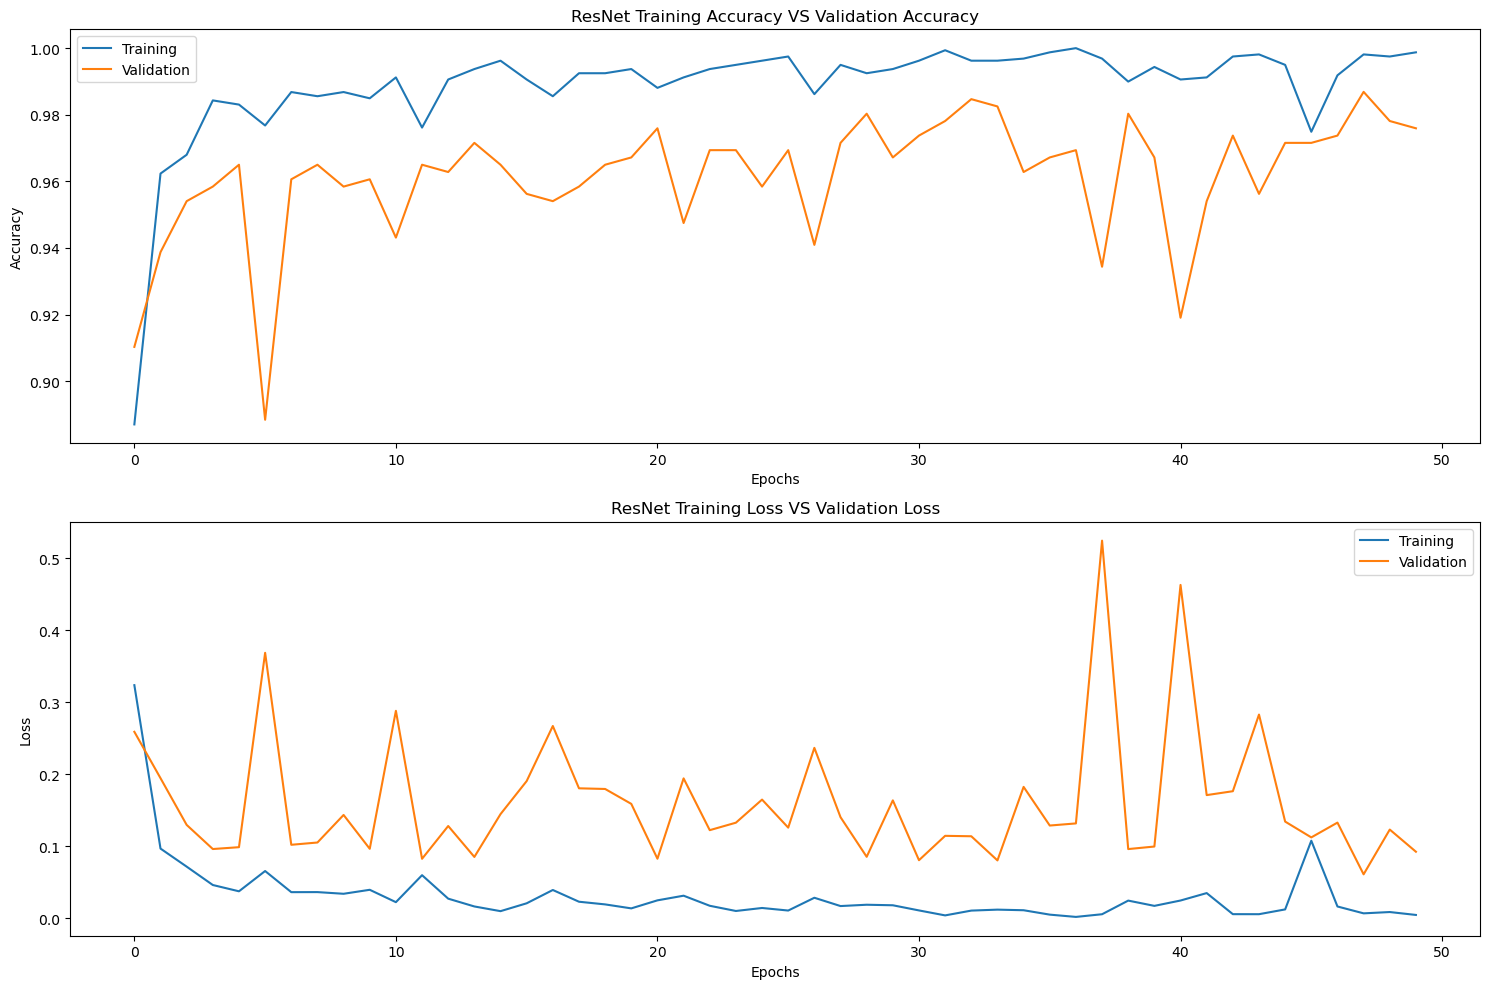

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot Training Accuracy and Validation Accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('ResNet Training Accuracy VS Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Training', 'Validation'])

# Plot Training Loss and Validation Loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('ResNet Training Loss VS Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend(['Training', 'Validation'])

plt.tight_layout()
plt.show()


In [20]:
import glob
# Loading the best model
saved_models_dir = '/kaggle/working/Resnet/'
saved_model_files = glob.glob(os.path.join(saved_models_dir, '*.h5'))
saved_model_files.sort()
best_model_file = saved_model_files[-1]
best_model = tf.keras.models.load_model(best_model_file)

# Saving the best model with a different name
best_model.save('/kaggle/working/Resnet/Saved_Model/Best_ResNet.h5')

In [21]:
# Evaluating the best model on the validation set
test_loss, test_acc = best_model.evaluate(valid_generator, verbose = 2)
print('\nVal_accuracy: ', test_acc)
print('\nVal_loss: ', test_loss)

457/457 - 8s - loss: 0.1237 - accuracy: 0.9716 - 8s/epoch - 18ms/step

Val_accuracy:  0.9715536236763

Val_loss:  0.12373828887939453


for best Resnet model
1/1 [==============================] - 0s 21ms/step
test accuracy :95.6043956043956


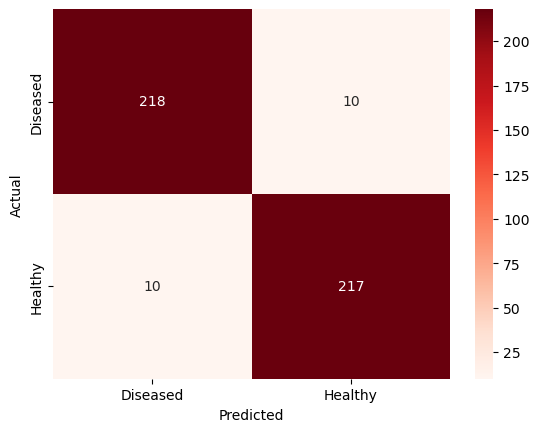

              precision    recall  f1-score   support

    Diseased       0.96      0.96      0.96       228
     Healthy       0.96      0.96      0.96       227

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455



In [22]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

print("for best Resnet model")
model = tf.keras.models.load_model('/kaggle/working/Resnet/Saved_Model/Best_ResNet.h5')

filenames = test_generator.filenames
nb_samples = len(test_generator)

y_prob = []
y_act = []

test_generator.reset()
for _ in range(nb_samples):
    X_test, Y_test = test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Reds', annot=True, fmt='d')
print('test accuracy :{}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))
# Generate classification report
plt.show()
classification_rep = classification_report(out_df['actual_class'], out_df['predicted_class'], target_names=target_names)

print(classification_rep)

Epoch 1
1/1 [==============================] - 0s 22ms/step


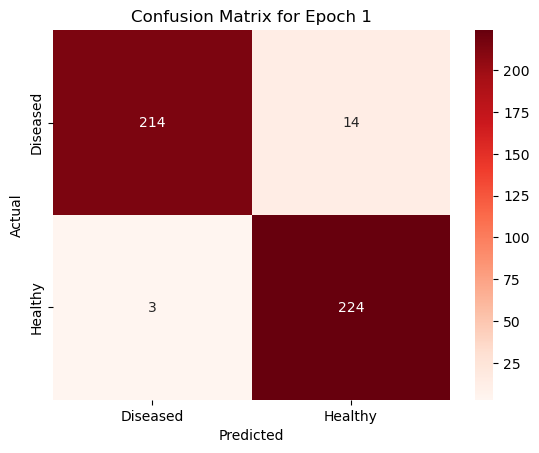

Test accuracy: 96.26373626373626
              precision    recall  f1-score   support

    Diseased       0.99      0.94      0.96       228
     Healthy       0.94      0.99      0.96       227

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455

-----------------------------------------------------
Epoch 2
1/1 [==============================] - 0s 23ms/step


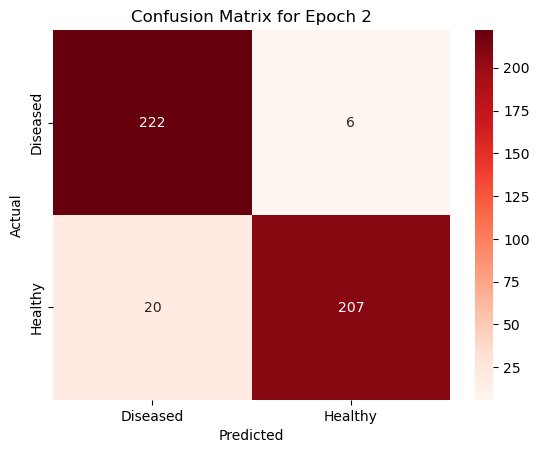

Test accuracy: 94.28571428571428
              precision    recall  f1-score   support

    Diseased       0.92      0.97      0.94       228
     Healthy       0.97      0.91      0.94       227

    accuracy                           0.94       455
   macro avg       0.94      0.94      0.94       455
weighted avg       0.94      0.94      0.94       455

-----------------------------------------------------
Epoch 3
1/1 [==============================] - 0s 23ms/step


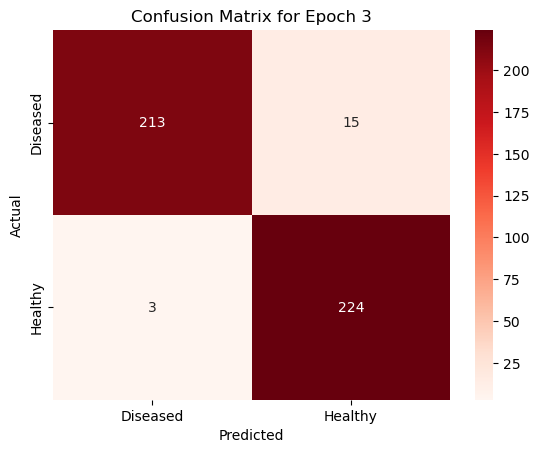

Test accuracy: 96.04395604395604
              precision    recall  f1-score   support

    Diseased       0.99      0.93      0.96       228
     Healthy       0.94      0.99      0.96       227

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455

-----------------------------------------------------
Epoch 4
1/1 [==============================] - 0s 22ms/step


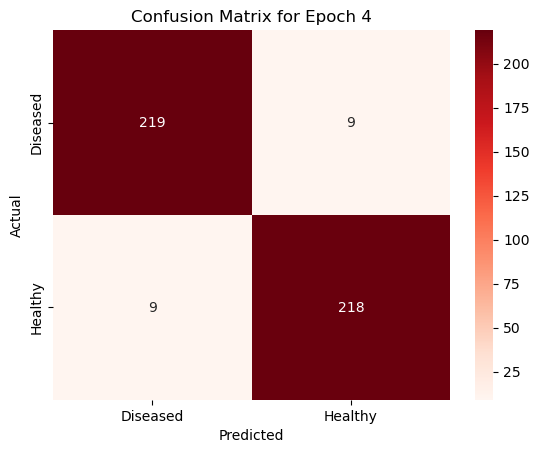

Test accuracy: 96.04395604395604
              precision    recall  f1-score   support

    Diseased       0.96      0.96      0.96       228
     Healthy       0.96      0.96      0.96       227

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455

-----------------------------------------------------
Epoch 5
1/1 [==============================] - 0s 22ms/step


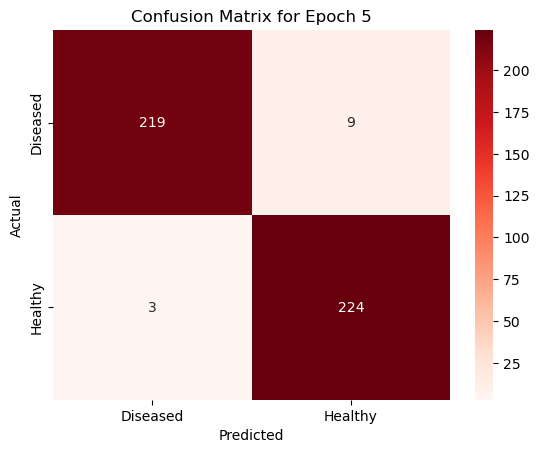

Test accuracy: 97.36263736263736
              precision    recall  f1-score   support

    Diseased       0.99      0.96      0.97       228
     Healthy       0.96      0.99      0.97       227

    accuracy                           0.97       455
   macro avg       0.97      0.97      0.97       455
weighted avg       0.97      0.97      0.97       455

-----------------------------------------------------


In [23]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

saved_model_filepaths = [
    '/kaggle/working/Resnet/save_by_epochs/Resnet_model_10.h5',
    '/kaggle/working/Resnet/save_by_epochs/Resnet_model_20.h5',
    '/kaggle/working/Resnet/save_by_epochs/Resnet_model_30.h5',
    '/kaggle/working/Resnet/save_by_epochs/Resnet_model_40.h5',
    '/kaggle/working/Resnet/save_by_epochs/Resnet_model_50.h5'
]

# Iterate over the saved model file paths
for epoch, model_filepath in enumerate(saved_model_filepaths, start=1):
    print("Epoch {}".format(epoch))
    
    # Load the model
    model = tf.keras.models.load_model(model_filepath)

    filenames = test_generator.filenames
    nb_samples = len(test_generator)

    y_prob = []
    y_act = []

    test_generator.reset()
    for _ in range(nb_samples):
        X_test, Y_test = test_generator.next()
        y_prob.append(model.predict(X_test))
        y_act.append(Y_test)

    predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
    actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

    out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class', 'actual_class'])

    confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

    sn.heatmap(confusion_matrix, cmap='Reds', annot=True, fmt='d')
    plt.title('Confusion Matrix for Epoch {}'.format(epoch))
    plt.show()

    print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum() / confusion_matrix.sum().sum() * 100)))

    # Generate classification report
    classification_rep = classification_report(out_df['actual_class'], out_df['predicted_class'], target_names=target_names)
    print(classification_rep)
    print("-----------------------------------------------------")
